In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt

con = sqlite3.connect('./bench.db')
cur = con.cursor()
df = pd.read_sql_query("SELECT * from scanned", con)

In [2]:
#maxboone@MacBook-Pro-van-Max bad-snakes-revisited % wc -l ./bench/*.batch
#   21071 ./bench/backstabbers.batch
#    9780 ./bench/datadog.batch
#    6658 ./bench/dependents.batch
#    7008 ./bench/downloaded.batch
#    4054 ./bench/maloss.batch
#   20595 ./bench/malregistry.batch
#    9731 ./bench/random.batch
#   78897 total

print(f'''
Dataset sizes in batch scripts:
    Backstabbers:         {int(21071 / 7)}
    Datadog:              {int( 9780 / 7)}
    Top 1000 Deps:        {int( 6658 / 7)}
    Top 1000 Downloaded:  {int( 7008 / 7)}
    MalOSS:               {int( 4054 / 7)}
    MalRegistry:          {int(20595 / 7)}
    Random:               {int( 9731 / 7)}
''')


Dataset sizes in batch scripts:
    Backstabbers:         3010
    Datadog:              1397
    Top 1000 Deps:        951
    Top 1000 Downloaded:  1001
    MalOSS:               579
    MalRegistry:          2942
    Random:               1390



In [3]:
# root@ubuntu-32gb-fsn1-1:~/bad-snakes-revisited/bad-snakes-revisited/packages/download/backstabbers/samples/pypi# find . -type f | wc -l
# 3024
print("Backstabbers: 3024 packages")

# root@ubuntu-32gb-fsn1-1:~/bad-snakes-revisited/bad-snakes-revisited/packages/download/datadog/samples/pypi# find . -type f | wc -l
# 1398
print("Datadog: 1398 packages")

# root@ubuntu-32gb-fsn1-1:~/bad-snakes-revisited/bad-snakes-revisited/packages/download/dependents# find . -type f | wc -l
# 951
print("Dependents: 951 packages")

# root@ubuntu-32gb-fsn1-1:~/bad-snakes-revisited/bad-snakes-revisited/packages/download/maloss/pypi-samples# find . -type f | wc -l
# 608
print("MalOSS: 608 packages")

# root@ubuntu-32gb-fsn1-1:~/bad-snakes-revisited/bad-snakes-revisited/packages/download/maloss/pypi-samples# find . -type f -name '*.tar.gz' | wc -l
# 579
print("MalOSS: 579 packages with source")

# root@ubuntu-32gb-fsn1-1:~/bad-snakes-revisited/bad-snakes-revisited/packages/download/malregistry# find . -type f | wc -l
# 2951
print("MalRegistry: 2951 packages")

# root@ubuntu-32gb-fsn1-1:~/bad-snakes-revisited/bad-snakes-revisited/packages/download/random# find . -type f  | wc -l
# 1390
print("Random: 1390 packages")

Backstabbers: 3024 packages
Datadog: 1398 packages
Dependents: 951 packages
MalOSS: 608 packages
MalOSS: 579 packages with source
MalRegistry: 2951 packages
Random: 1390 packages


In [4]:
# remove all the output information from the filename
df['package'] = df['filename'].str.split('.tar.gz').str[0]
df['package'] = df['filename'].str.split('.zip').str[0]

In [5]:
# mark malicious sources as malicious
df['malicious'] = np.nan
df['malicious'] = df['malicious'].astype(bool)
df.loc[df['source'] == 'malregistry', 'malicious'] = True
df.loc[df['source'] == 'datadog', 'malicious'] = True
df.loc[df['source'] == 'backstabbers', 'malicious'] = True
df.loc[df['source'] == 'maloss', 'malicious'] = True

df.loc[df['source'] == 'random', 'malicious'] = False
df.loc[df['source'] == 'downloaded', 'malicious'] = False
df.loc[df['source'] == 'dependents', 'malicious'] = False

In [6]:
# our parsing script had an error splitting packages with spaces, from that
# keep only the first result (incomplete but unique names)
df = df[df['source'] != '']

In [7]:
# We scan each package 7 times (4 times fully, 3 times setup only), so divide the value counts by 7
# packages before deduplication
(df['source'].value_counts() / 7).astype(int)

source
backstabbers    2985
malregistry     2919
datadog         1397
random          1392
downloaded      1001
dependents       951
maloss           584
Name: count, dtype: int64

In [8]:
# drop packages that are in multiple datasets
df = df.drop_duplicates(subset=['package', 'scanner'])

In [9]:
# amount of malicious packages
(df['malicious'].value_counts() / 7).astype(int)

malicious
True     4182
False    2750
Name: count, dtype: int64

In [10]:
# packages per source after deduplication
(df['source'].value_counts() / 7).astype(int)

source
backstabbers    2778
random          1384
dependents       951
datadog          798
maloss           584
downloaded       414
malregistry       21
Name: count, dtype: int64

In [11]:
# note, guarddog did not scan the setup.py only, so we check full scope here
(df[df['scope'] == 'full']['scanner'].value_counts()).astype(int)

scanner
guarddog      7520
pypi          6846
bandit4mal    6812
ossgadget     6811
Name: count, dtype: int64

In [12]:
df['alerts'] = df['severity_high'] + df['severity_medium'] + df['severity_low']

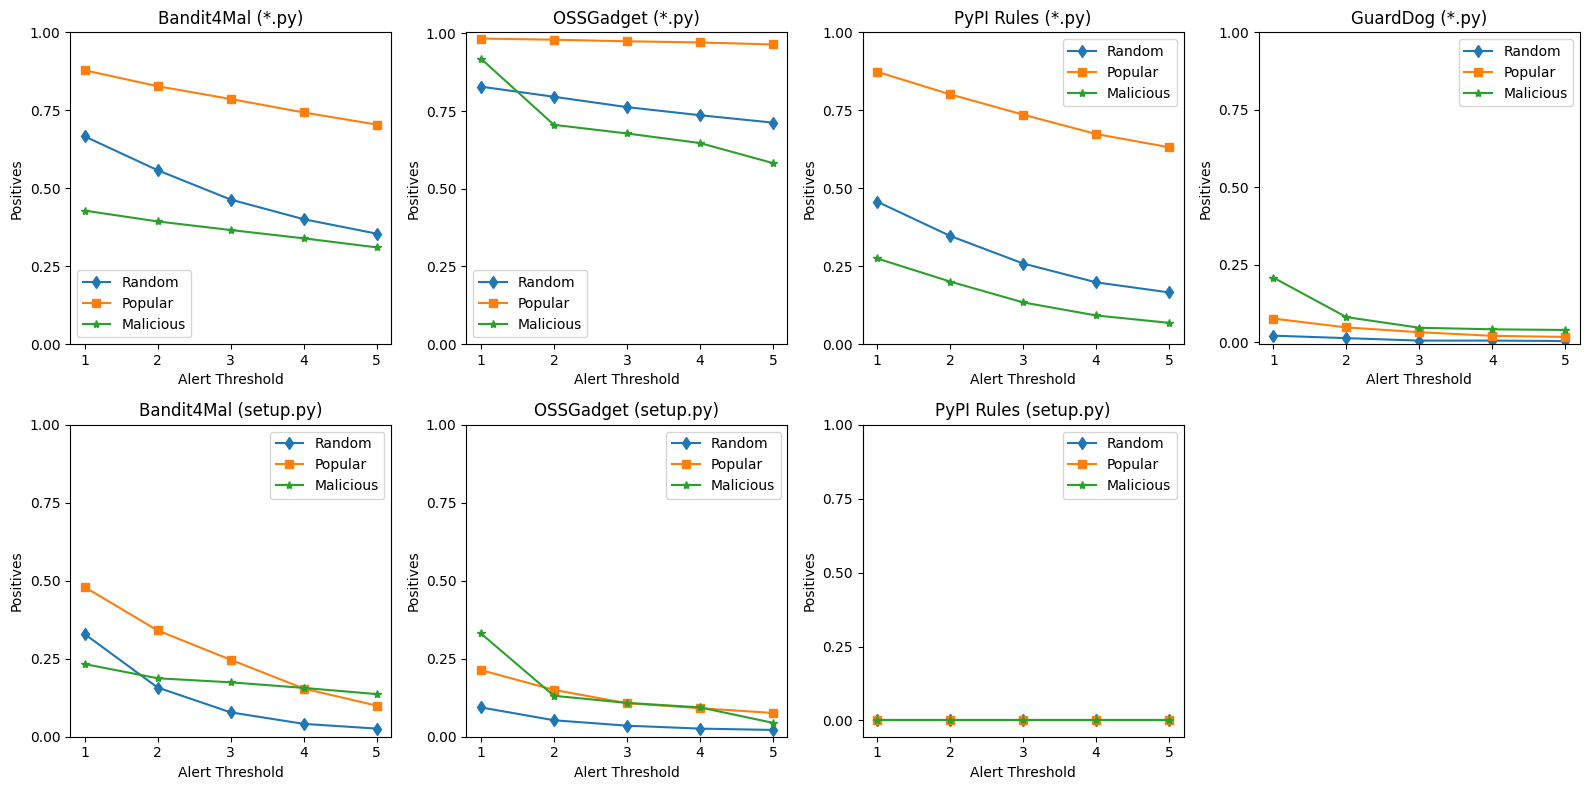

In [13]:
random_slice = df[(df['source'] == 'random')]
benign_slice = df[(df['source'] == 'dependents') | (df['source'] == 'downloaded')]
malicious_slice = df[df['malicious']]

scanners = ['guarddog', 'bandit4mal', 'pypi', 'ossgadget']
x = [1, 2, 3, 4, 5]

slices = {
    key: [
        random_slice[(random_slice['scope'] == 'full') & (random_slice['scanner'] == key)],
        benign_slice[(benign_slice['scope'] == 'full') & (benign_slice['scanner'] == key)],
        malicious_slice[(malicious_slice['scope'] == 'full') & (malicious_slice['scanner'] == key)],
    ] for key in ['guarddog', 'bandit4mal', 'pypi', 'ossgadget']
}

slices_setup = {
    key: [
        random_slice[(random_slice['scope'] == 'setup') & (random_slice['scanner'] == key)],
        benign_slice[(benign_slice['scope'] == 'setup') & (benign_slice['scanner'] == key)],
        malicious_slice[(malicious_slice['scope'] == 'setup') & (malicious_slice['scanner'] == key)],
    ] for key in ['bandit4mal', 'pypi', 'ossgadget']
}

y = {
    key: [
        [len(slices[key][0][slices[key][0]['alerts'] > i]) / len(slices[key][0]) for i in x],
        [len(slices[key][1][slices[key][1]['alerts'] > i]) / len(slices[key][1]) for i in x],
        [len(slices[key][2][slices[key][2]['alerts'] > i]) / len(slices[key][2]) for i in x],
    ] for key in ['guarddog', 'bandit4mal', 'pypi', 'ossgadget']
}

y_setup = {
    key: [
        [len(slices_setup[key][0][slices_setup[key][0]['alerts'] > i]) / len(slices_setup[key][0]) for i in x],
        [len(slices_setup[key][1][slices_setup[key][1]['alerts'] > i]) / len(slices_setup[key][1]) for i in x],
        [len(slices_setup[key][2][slices_setup[key][2]['alerts'] > i]) / len(slices_setup[key][2]) for i in x],
    ] for key in ['bandit4mal', 'pypi', 'ossgadget']
}
 
# Plotting
# plt.plot(x, y['guarddog'][0], 'd-', label='Random')
# plt.plot(x, y['guarddog'][1], 's-', label='Popular')
# plt.plot(x, y['guarddog'][2], '*-', label='Malicious')

# Adding labels and title
# plt.xlabel('Alert Threshold')
# plt.ylabel('Positives')
# plt.title('Alert percentages (Guarddog)')
# plt.yticks([0, 0.25, 0.5, 0.75, 1])
# plt.xticks([1, 2, 3, 4, 5])
# plt.legend()
# plt.show()

scanner_names = ['Bandit4Mal', 'OSSGadget', 'PyPI Rules', 'GuardDog']
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
axes = axes.flatten()

# Plot each set of data on a separate subplot
for i, label in enumerate(['bandit4mal', 'ossgadget', 'pypi', 'guarddog']):
    axes[i].plot(x, y[label][0], marker='d', linestyle='-', label='Random')
    axes[i].plot(x, y[label][1], marker='s', linestyle='-', label='Popular')
    axes[i].plot(x, y[label][2], marker='*', linestyle='-', label='Malicious')

    axes[i].set_title(f'{scanner_names[i]} (*.py)')
    axes[i].set_xlabel('Alert Threshold')
    axes[i].set_ylabel('Positives')
    axes[i].set_yticks([0, 0.25, 0.5, 0.75, 1])
    axes[i].set_xticks([1, 2, 3, 4, 5])
    axes[i].legend()

for i, label in enumerate(['bandit4mal', 'ossgadget', 'pypi']):
    axes[i + 4].plot(x, y_setup[label][0], marker='d', linestyle='-', label='Random')
    axes[i + 4].plot(x, y_setup[label][1], marker='s', linestyle='-', label='Popular')
    axes[i + 4].plot(x, y_setup[label][2], marker='*', linestyle='-', label='Malicious')

    axes[i + 4].set_title(f'{scanner_names[i]} (setup.py)')
    axes[i + 4].set_xlabel('Alert Threshold')
    axes[i + 4].set_ylabel('Positives')
    axes[i + 4].set_yticks([0, 0.25, 0.5, 0.75, 1])
    axes[i + 4].set_xticks([1, 2, 3, 4, 5])
    axes[i + 4].legend()

axes[-1].set_visible(False)
# Adjust layout and show the plot
plt.tight_layout()
plt.show()

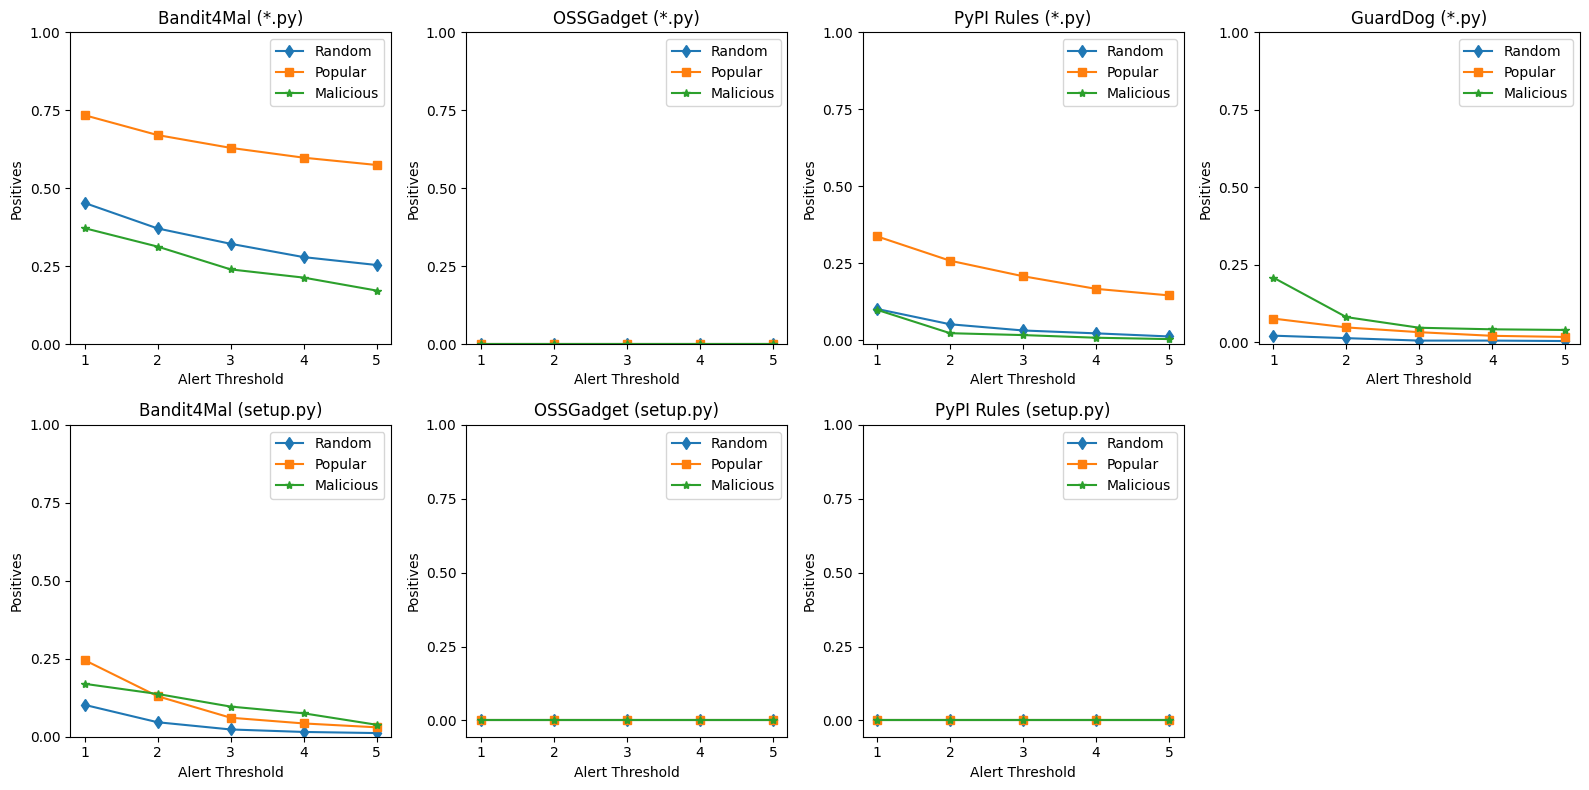

In [14]:
random_slice = df[(df['source'] == 'random')]
benign_slice = df[(df['source'] == 'dependents') | (df['source'] == 'downloaded')]
malicious_slice = df[df['malicious']]

scanners = ['guarddog', 'bandit4mal', 'pypi', 'ossgadget']
x = [1, 2, 3, 4, 5]

slices = {
    key: [
        random_slice[(random_slice['scope'] == 'full') & (random_slice['scanner'] == key)],
        benign_slice[(benign_slice['scope'] == 'full') & (benign_slice['scanner'] == key)],
        malicious_slice[(malicious_slice['scope'] == 'full') & (malicious_slice['scanner'] == key)],
    ] for key in ['guarddog', 'bandit4mal', 'pypi', 'ossgadget']
}

slices_setup = {
    key: [
        random_slice[(random_slice['scope'] == 'setup') & (random_slice['scanner'] == key)],
        benign_slice[(benign_slice['scope'] == 'setup') & (benign_slice['scanner'] == key)],
        malicious_slice[(malicious_slice['scope'] == 'setup') & (malicious_slice['scanner'] == key)],
    ] for key in ['bandit4mal', 'pypi', 'ossgadget']
}

y = {
    key: [
        [len(slices[key][0][slices[key][0]['severity_high'] > i]) / len(slices[key][0]) for i in x],
        [len(slices[key][1][slices[key][1]['severity_high'] > i]) / len(slices[key][1]) for i in x],
        [len(slices[key][2][slices[key][2]['severity_high'] > i]) / len(slices[key][2]) for i in x],
    ] for key in ['guarddog', 'bandit4mal', 'pypi', 'ossgadget']
}

y_setup = {
    key: [
        [len(slices_setup[key][0][slices_setup[key][0]['severity_high'] > i]) / len(slices_setup[key][0]) for i in x],
        [len(slices_setup[key][1][slices_setup[key][1]['severity_high'] > i]) / len(slices_setup[key][1]) for i in x],
        [len(slices_setup[key][2][slices_setup[key][2]['severity_high'] > i]) / len(slices_setup[key][2]) for i in x],
    ] for key in ['bandit4mal', 'pypi', 'ossgadget']
}
 
# Plotting
# plt.plot(x, y['guarddog'][0], 'd-', label='Random')
# plt.plot(x, y['guarddog'][1], 's-', label='Popular')
# plt.plot(x, y['guarddog'][2], '*-', label='Malicious')

# Adding labels and title
# plt.xlabel('Alert Threshold')
# plt.ylabel('Positives')
# plt.title('Alert percentages (Guarddog)')
# plt.yticks([0, 0.25, 0.5, 0.75, 1])
# plt.xticks([1, 2, 3, 4, 5])
# plt.legend()
# plt.show()

scanner_names = ['Bandit4Mal', 'OSSGadget', 'PyPI Rules', 'GuardDog']
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
axes = axes.flatten()

# Plot each set of data on a separate subplot
for i, label in enumerate(['bandit4mal', 'ossgadget', 'pypi', 'guarddog']):
    axes[i].plot(x, y[label][0], marker='d', linestyle='-', label='Random')
    axes[i].plot(x, y[label][1], marker='s', linestyle='-', label='Popular')
    axes[i].plot(x, y[label][2], marker='*', linestyle='-', label='Malicious')

    axes[i].set_title(f'{scanner_names[i]} (*.py)')
    axes[i].set_xlabel('Alert Threshold')
    axes[i].set_ylabel('Positives')
    axes[i].set_yticks([0, 0.25, 0.5, 0.75, 1])
    axes[i].set_xticks([1, 2, 3, 4, 5])
    axes[i].legend()

for i, label in enumerate(['bandit4mal', 'ossgadget', 'pypi']):
    axes[i + 4].plot(x, y_setup[label][0], marker='d', linestyle='-', label='Random')
    axes[i + 4].plot(x, y_setup[label][1], marker='s', linestyle='-', label='Popular')
    axes[i + 4].plot(x, y_setup[label][2], marker='*', linestyle='-', label='Malicious')

    axes[i + 4].set_title(f'{scanner_names[i]} (setup.py)')
    axes[i + 4].set_xlabel('Alert Threshold')
    axes[i + 4].set_ylabel('Positives')
    axes[i + 4].set_yticks([0, 0.25, 0.5, 0.75, 1])
    axes[i + 4].set_xticks([1, 2, 3, 4, 5])
    axes[i + 4].legend()

axes[-1].set_visible(False)
# Adjust layout and show the plot
plt.tight_layout()
plt.show()

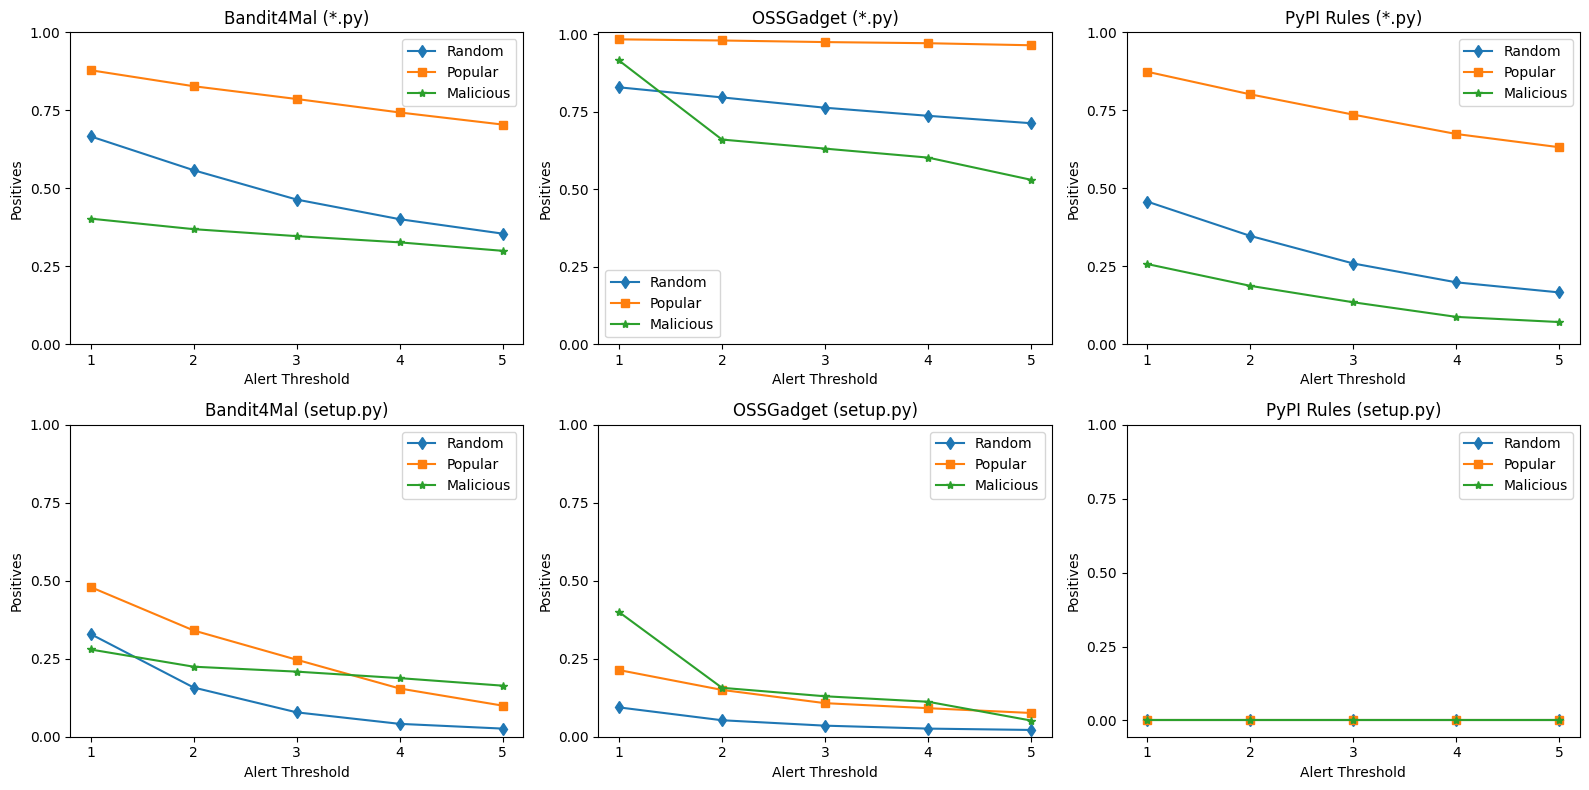

In [15]:
random_slice = df[(df['source'] == 'random')]
benign_slice = df[(df['source'] == 'dependents') | (df['source'] == 'downloaded')]
malicious_slice = df[(df['source'] == 'backstabbers') | (df['source'] == 'maloss')]

scanners = ['bandit4mal', 'pypi', 'ossgadget']
x = [1, 2, 3, 4, 5]

slices = {
    key: [
        random_slice[(random_slice['scope'] == 'full') & (random_slice['scanner'] == key)],
        benign_slice[(benign_slice['scope'] == 'full') & (benign_slice['scanner'] == key)],
        malicious_slice[(malicious_slice['scope'] == 'full') & (malicious_slice['scanner'] == key)],
    ] for key in ['bandit4mal', 'pypi', 'ossgadget']
}

slices_setup = {
    key: [
        random_slice[(random_slice['scope'] == 'setup') & (random_slice['scanner'] == key)],
        benign_slice[(benign_slice['scope'] == 'setup') & (benign_slice['scanner'] == key)],
        malicious_slice[(malicious_slice['scope'] == 'setup') & (malicious_slice['scanner'] == key)],
    ] for key in ['bandit4mal', 'pypi', 'ossgadget']
}

y = {
    key: [
        [len(slices[key][0][slices[key][0]['alerts'] > i]) / len(slices[key][0]) for i in x],
        [len(slices[key][1][slices[key][1]['alerts'] > i]) / len(slices[key][1]) for i in x],
        [len(slices[key][2][slices[key][2]['alerts'] > i]) / len(slices[key][2]) for i in x],
    ] for key in ['bandit4mal', 'pypi', 'ossgadget']
}

y_setup = {
    key: [
        [len(slices_setup[key][0][slices_setup[key][0]['alerts'] > i]) / len(slices_setup[key][0]) for i in x],
        [len(slices_setup[key][1][slices_setup[key][1]['alerts'] > i]) / len(slices_setup[key][1]) for i in x],
        [len(slices_setup[key][2][slices_setup[key][2]['alerts'] > i]) / len(slices_setup[key][2]) for i in x],
    ] for key in ['bandit4mal', 'pypi', 'ossgadget']
}
 
# Plotting
# plt.plot(x, y['guarddog'][0], 'd-', label='Random')
# plt.plot(x, y['guarddog'][1], 's-', label='Popular')
# plt.plot(x, y['guarddog'][2], '*-', label='Malicious')

# Adding labels and title
# plt.xlabel('Alert Threshold')
# plt.ylabel('Positives')
# plt.title('Alert percentages (Guarddog)')
# plt.yticks([0, 0.25, 0.5, 0.75, 1])
# plt.xticks([1, 2, 3, 4, 5])
# plt.legend()
# plt.show()

scanner_names = ['Bandit4Mal', 'OSSGadget', 'PyPI Rules']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))
axes = axes.flatten()

# Plot each set of data on a separate subplot
for i, label in enumerate(['bandit4mal', 'ossgadget', 'pypi']):
    axes[i].plot(x, y[label][0], marker='d', linestyle='-', label='Random')
    axes[i].plot(x, y[label][1], marker='s', linestyle='-', label='Popular')
    axes[i].plot(x, y[label][2], marker='*', linestyle='-', label='Malicious')

    axes[i].set_title(f'{scanner_names[i]} (*.py)')
    axes[i].set_xlabel('Alert Threshold')
    axes[i].set_ylabel('Positives')
    axes[i].set_yticks([0, 0.25, 0.5, 0.75, 1])
    axes[i].set_xticks([1, 2, 3, 4, 5])
    axes[i].legend()

for i, label in enumerate(['bandit4mal', 'ossgadget', 'pypi']):
    axes[i + 3].plot(x, y_setup[label][0], marker='d', linestyle='-', label='Random')
    axes[i + 3].plot(x, y_setup[label][1], marker='s', linestyle='-', label='Popular')
    axes[i + 3].plot(x, y_setup[label][2], marker='*', linestyle='-', label='Malicious')

    axes[i + 3].set_title(f'{scanner_names[i]} (setup.py)')
    axes[i + 3].set_xlabel('Alert Threshold')
    axes[i + 3].set_ylabel('Positives')
    axes[i + 3].set_yticks([0, 0.25, 0.5, 0.75, 1])
    axes[i + 3].set_xticks([1, 2, 3, 4, 5])
    axes[i + 3].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

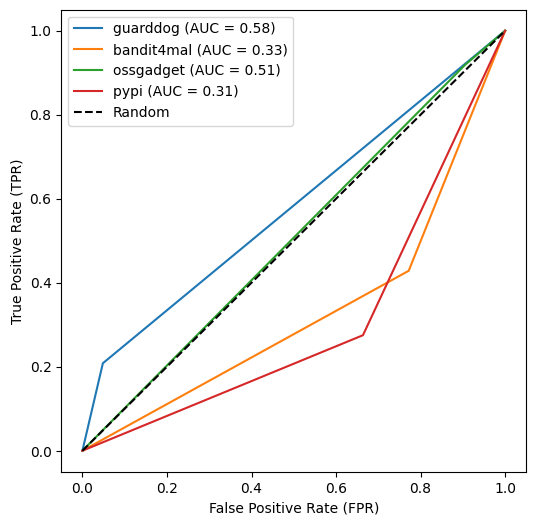

In [16]:
from sklearn.metrics import roc_curve, auc
# Assuming df is your DataFrame

# Define the scanners you want to analyze
scanners = ['guarddog', 'bandit4mal', 'ossgadget', 'pypi']

# Initialize an empty DataFrame to store the results
scanner_list, fpr_list, tpr_list, auc_list = [], [], [], []

# Loop through each scanner and calculate ROC AUC
for scanner in scanners:
    y_true = df[(df['scope'] == 'full') & (df['scanner'] == scanner)].malicious
    y_scores = (df[(df['scope'] == 'full') & (df['scanner'] == scanner)].alerts > 1)

    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Store the results in the DataFrame
    scanner_list.append(scanner)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(roc_auc)

roc_results = pd.DataFrame({'Scanner': scanner_list, 'FPR': fpr_list, 'TPR': tpr_list, 'AUC': auc_list})

# Plot ROC curves
plt.figure(figsize=(6, 6))
for index, row in roc_results.iterrows():
    plt.plot(row['FPR'], row['TPR'], label=f"{row['Scanner']} (AUC = {row['AUC']:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.show()

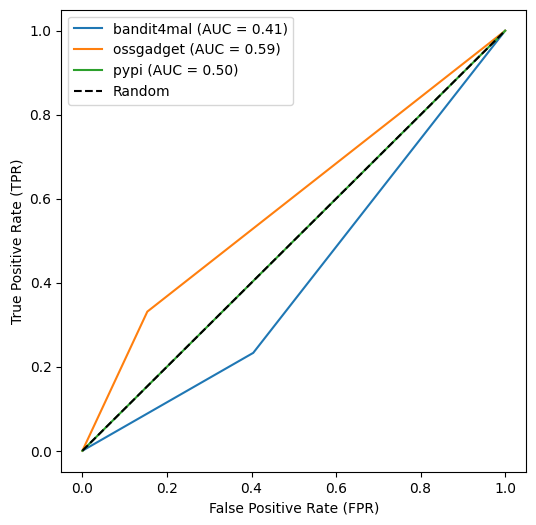

In [17]:
from sklearn.metrics import roc_curve, auc
# Assuming df is your DataFrame

# Define the scanners you want to analyze
scanners = ['bandit4mal', 'ossgadget', 'pypi']

# Initialize an empty DataFrame to store the results
scanner_list, fpr_list, tpr_list, auc_list = [], [], [], []

# Loop through each scanner and calculate ROC AUC
for scanner in scanners:
    y_true = df[(df['scope'] == 'setup') & (df['scanner'] == scanner)].malicious
    y_scores = (df[(df['scope'] == 'setup') & (df['scanner'] == scanner)].alerts > 1)

    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Store the results in the DataFrame
    scanner_list.append(scanner)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(roc_auc)

roc_results = pd.DataFrame({'Scanner': scanner_list, 'FPR': fpr_list, 'TPR': tpr_list, 'AUC': auc_list})

# Plot ROC curves
plt.figure(figsize=(6, 6))
for index, row in roc_results.iterrows():
    plt.plot(row['FPR'], row['TPR'], label=f"{row['Scanner']} (AUC = {row['AUC']:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.show()

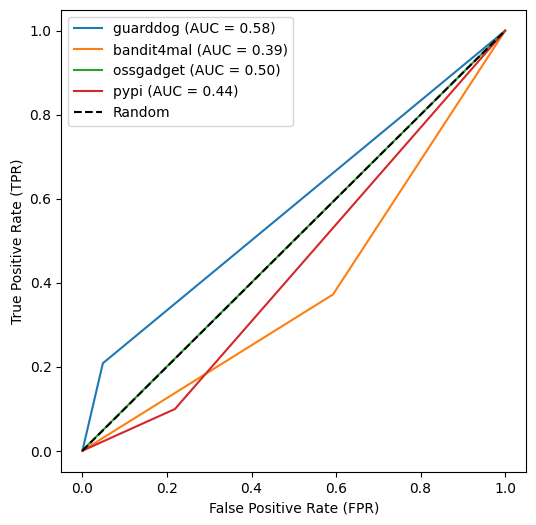

In [18]:
from sklearn.metrics import roc_curve, auc
# Assuming df is your DataFrame

# Define the scanners you want to analyze
scanners = ['guarddog', 'bandit4mal', 'ossgadget', 'pypi']

# Initialize an empty DataFrame to store the results
scanner_list, fpr_list, tpr_list, auc_list = [], [], [], []

# Loop through each scanner and calculate ROC AUC
for scanner in scanners:
    y_true = df[(df['scope'] == 'full') & (df['scanner'] == scanner)].malicious
    y_scores = (df[(df['scope'] == 'full') & (df['scanner'] == scanner)].severity_high > 1)

    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Store the results in the DataFrame
    scanner_list.append(scanner)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(roc_auc)

roc_results = pd.DataFrame({'Scanner': scanner_list, 'FPR': fpr_list, 'TPR': tpr_list, 'AUC': auc_list})

# Plot ROC curves
plt.figure(figsize=(6, 6))
for index, row in roc_results.iterrows():
    plt.plot(row['FPR'], row['TPR'], label=f"{row['Scanner']} (AUC = {row['AUC']:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.show()

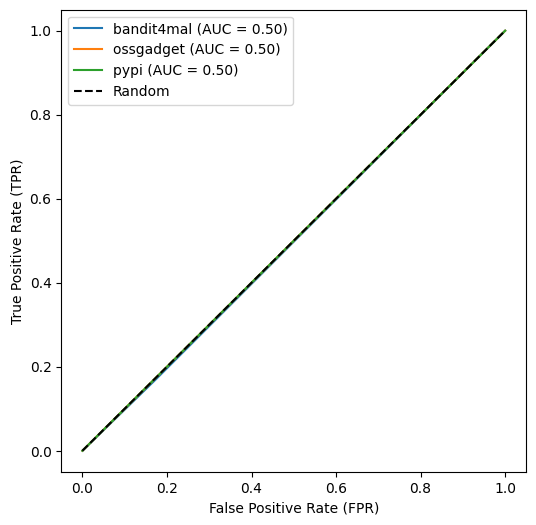

In [19]:
from sklearn.metrics import roc_curve, auc
# Assuming df is your DataFrame

# Define the scanners you want to analyze
scanners = ['bandit4mal', 'ossgadget', 'pypi']

# Initialize an empty DataFrame to store the results
scanner_list, fpr_list, tpr_list, auc_list = [], [], [], []

# Loop through each scanner and calculate ROC AUC
for scanner in scanners:
    y_true = df[(df['scope'] == 'setup') & (df['scanner'] == scanner)].malicious
    y_scores = (df[(df['scope'] == 'setup') & (df['scanner'] == scanner)].severity_high > 1)

    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Store the results in the DataFrame
    scanner_list.append(scanner)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(roc_auc)

roc_results = pd.DataFrame({'Scanner': scanner_list, 'FPR': fpr_list, 'TPR': tpr_list, 'AUC': auc_list})

# Plot ROC curves
plt.figure(figsize=(6, 6))
for index, row in roc_results.iterrows():
    plt.plot(row['FPR'], row['TPR'], label=f"{row['Scanner']} (AUC = {row['AUC']:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.show()